In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import nfp

print(f"tensorflow {tf.__version__}")
print(f"nfp {nfp.__version__}")

tensorflow 2.8.0
nfp 0+unknown


## Loading Dataset

In [2]:
qm9 = pd.read_csv("qm9.csv")
qm9.head(10)

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
5,gdb_6,C=O,285.48839,38.982300,34.298920,2.1089,14.18,-0.2670,-0.0406,0.2263,...,0.026603,-114.483613,-114.480746,-114.479802,-114.505268,6.413,-358.756935,-360.512706,-362.291066,-340.464421
6,gdb_7,CC,80.46225,19.906490,19.906330,0.0000,23.95,-0.3385,0.1041,0.4426,...,0.074542,-79.764152,-79.760666,-79.759722,-79.787269,10.098,-670.788296,-675.710476,-679.860821,-626.927299
7,gdb_8,CO,127.83497,24.858720,23.978720,1.5258,16.97,-0.2653,0.0784,0.3437,...,0.051208,-115.679136,-115.675816,-115.674872,-115.701876,8.751,-481.106758,-484.355372,-487.319724,-450.124128
8,gdb_9,CC#C,160.28041,8.593230,8.593210,0.7156,28.78,-0.2609,0.0613,0.3222,...,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,-670.268091,-673.980434,-677.537155,-631.346845
9,gdb_10,CC#N,159.03567,9.223270,9.223240,3.8266,24.45,-0.3264,0.0376,0.3640,...,0.045286,-132.718150,-132.714563,-132.713619,-132.742149,10.287,-589.812024,-592.893721,-595.857446,-557.125708


## Remove duplicate SMILES

In [3]:
# Remove duplicates
qm9 = qm9.drop_duplicates(subset='smiles', keep="first")

## Split Dataset (60% 20% 20%)

In [5]:
# Following 20% validation, 20% testing, 60% training size

valid, test, train = np.split(qm9.smiles.sample(frac=1., random_state=123), [26760, 53520])
len(train), len(valid), len(test)

(80282, 26760, 26760)

## Define how to featurize the input molecules

In [6]:
from nfp.preprocessing.mol_preprocessor import SmilesPreprocessor
from nfp.preprocessing.features import get_ring_size


def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return str((
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))


def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = 'R{}'.format(get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''
    
    return " ".join([atoms, btype, ring]).strip()


preprocessor = SmilesPreprocessor(atom_features=atom_featurizer, bond_features=bond_featurizer,
                                  explicit_hs=False)

In [7]:
# Initially, the preprocessor has no data on atom types, so we have to loop over the 
# training set once to pre-allocate these mappings
print("before pre-allocating")
print(preprocessor.atom_tokenizer._data)

for smiles in train:
    preprocessor(smiles, train=True)
    
print()
print("after pre-allocating")
print(preprocessor.atom_tokenizer._data)

before pre-allocating
{'unk': 1}


2022-04-07 17:09:43.574201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



after pre-allocating
{'unk': 1, "('C', False, 0, 1, 3)": 2, "('C', False, 0, 2, 2)": 3, "('O', False, 0, 2, 0)": 4, "('C', False, 4, 3, 1)": 5, "('C', False, 4, 2, 2)": 6, "('O', False, 0, 1, 1)": 7, "('C', False, 0, 3, 0)": 8, "('C', False, 3, 3, 1)": 9, "('C', False, 3, 2, 2)": 10, "('O', False, 3, 2, 0)": 11, "('N', False, 0, 2, 0)": 12, "('C', False, 4, 4, 0)": 13, "('C', False, 0, 2, 0)": 14, "('N', False, 0, 1, 0)": 15, "('O', False, 4, 2, 0)": 16, "('N', False, 4, 3, 0)": 17, "('C', False, 5, 2, 2)": 18, "('C', False, 3, 4, 0)": 19, "('O', False, 0, 1, 0)": 20, "('C', False, 0, 2, 1)": 21, "('C', False, 0, 3, 1)": 22, "('C', False, 5, 3, 1)": 23, "('O', False, 5, 2, 0)": 24, "('N', False, 0, 1, 3)": 25, "('C', False, 'max', 3, 1)": 26, "('C', False, 'max', 2, 2)": 27, "('N', False, 'max', 2, 1)": 28, "('C', False, 'max', 3, 0)": 29, "('N', False, 3, 3, 0)": 30, "('N', False, 5, 3, 0)": 31, "('C', False, 5, 4, 0)": 32, "('C', False, 5, 2, 1)": 33, "('N', False, 5, 2, 1)": 34, "(

## Construct Tensorflow Dataset

In [8]:
# Construct the tf.data pipeline. There's a lot of specifying data types and
# expected shapes for tensorflow to pre-allocate the necessary arrays. But 
# essentially, this is responsible for calling the input constructor, batching 
# together multiple molecules, and padding the resulting molecules so that all
# molecules in the same batch have the same number of atoms (we pad with zeros,
# hence why the atom and bond types above start with 1 as the unknown class)

train_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=False), row.h298)
             for i, row in qm9[qm9.smiles.isin(train)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=False), row.h298)
             for i, row in qm9[qm9.smiles.isin(valid)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache()\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
inputs, outputs = next(train_dataset.as_numpy_iterator())
inputs['atom']

2022-04-07 17:11:48.007462: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[ 6, 36, 20,  6, 16,  0],
       [ 2,  3,  4, 21, 20,  0],
       [ 2,  9, 10,  9,  2,  0],
       [ 2,  3,  3,  3,  2,  0],
       [41, 41, 39, 37, 20, 39],
       [ 2,  3,  3, 14, 15,  0],
       [ 3,  8, 20, 45,  7,  0],
       [41, 41, 37, 39, 41, 45],
       [ 2,  8, 20, 46, 21, 20],
       [ 2,  3,  3, 21, 20,  0],
       [54, 54, 53, 54, 54, 53],
       [ 2, 22,  7,  3, 14, 40],
       [ 2,  3,  3, 22,  2,  2],
       [ 3,  3,  7,  8, 20, 45],
       [41, 41, 38, 41, 42,  0],
       [41, 38, 41, 39, 38,  0],
       [ 2,  5,  6, 36, 57, 16],
       [ 2, 13,  6, 17,  6,  6],
       [54, 54, 54, 54, 54, 54],
       [ 2,  9, 11, 19,  2,  2],
       [54, 54, 54, 53, 54, 54],
       [ 8, 20, 45, 45,  0,  0],
       [21, 20, 45,  0,  0,  0],
       [ 2,  8, 20, 14, 40,  0],
       [ 2,  5,  6,  5,  2, 16],
       [ 3, 14, 15, 45,  0,  0],
       [ 3,  3,  7,  7,  0,  0],
       [ 3, 14, 15, 14, 15,  0],
       [21, 20, 21, 20,  0,  0],
       [ 3, 21, 20, 14, 15,  0],
       [18

## Creating and Training

In [39]:
## Define the keras model
from tensorflow.keras import layers

# Input layers
atom = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

num_features = 8  # Controls the size of the model

# Convert from a single integer defining the atom state to a vector
# of weights associated with that class
atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

# Ditto with the bond state
bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

# Here we use our first nfp layer. This is an attention layer that looks at
# the atom and bond states and reduces them to a single, graph-level vector. 
# mum_heads * units has to be the same dimension as the atom / bond dimension
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(3):  # Do the message passing
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = layers.Add()([bond_state, new_bond_state])
    
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = layers.Add()([atom_state, new_atom_state])
    
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = layers.Add()([global_state, new_global_state])

    
# Since the final prediction is a single, molecule-level property, we 
# reduce the last global state to a single prediction.
bde_prediction = layers.Dense(1)(global_state)

# Construct the tf.keras model
model = tf.keras.Model([atom, bond, connectivity], [bde_prediction])

In [44]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))

# Fit the model. The first epoch is slower, since it needs to cache
# the preprocessed molecule inputs
model.fit(train_dataset, validation_data=valid_dataset, epochs=25)

Epoch 1/25
1255/1255 [==============================] - 46s 22ms/step - loss: 3.5283 - val_loss: 11.5495
Epoch 2/25
1255/1255 [==============================] - 22s 17ms/step - loss: 3.5095 - val_loss: 13.7250
Epoch 3/25
1255/1255 [==============================] - 20s 16ms/step - loss: 3.3613 - val_loss: 11.6612
Epoch 4/25
1255/1255 [==============================] - 22s 18ms/step - loss: 3.4552 - val_loss: 12.6687
Epoch 5/25
1255/1255 [==============================] - 23s 18ms/step - loss: 3.5762 - val_loss: 11.9384
Epoch 6/25
1255/1255 [==============================] - 19s 15ms/step - loss: 3.1817 - val_loss: 11.8764
Epoch 7/25
1255/1255 [==============================] - 22s 17ms/step - loss: 3.3573 - val_loss: 11.6161
Epoch 8/25
1255/1255 [==============================] - 21s 16ms/step - loss: 3.1775 - val_loss: 11.4081
Epoch 9/25
1255/1255 [==============================] - 19s 15ms/step - loss: 3.3002 - val_loss: 11.4741
Epoch 10/25
1255/1255 [==============================] 

## Evaluating the model

In [45]:
# Here, we create a test dataset that doesn't assume we know the values for the bde

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor(smiles, train=False)
             for smiles in test),
    output_signature=preprocessor.output_signature)\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [46]:
# Here are the predictions on the test set
test_predictions = model.predict(test_dataset)
test_bde_values = qm9.loc[qm9['smiles'].isin(test)].h298

In [56]:
errors = test_bde_values - test_predictions.flatten()

# MAE
MAE = np.abs(errors).mean()
MAE

43.59701520581968

In [57]:
# RMSE
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(test_bde_values, test_predictions.flatten(), squared=False)
RMSE

56.29759345273275

In [58]:
# standard deviation of h298
qm9['h298'].std()

40.05609371697183

In [59]:
# “reduce values” = RMSE/std dev of target data
reduce_values = RMSE / (qm9['h298'].std())
reduce_values

1.4054688869693595

In [60]:
# MAE/MAD
MAE / (qm9['h298'].mad())

1.402796836476102

In [49]:
# MIN
min(errors)

-358.71968233422854

In [50]:
# MAX
max(errors)

409.4498723457031

(array([2.0000e+00, 5.0000e+00, 9.9000e+01, 2.6130e+03, 1.3464e+04,
        9.1110e+03, 1.3320e+03, 1.2500e+02, 6.0000e+00, 3.0000e+00]),
 array([-358.71968233, -281.90272687, -205.0857714 , -128.26881593,
         -51.45186046,   25.36509501,  102.18205047,  178.99900594,
         255.81596141,  332.63291688,  409.44987235]),
 <BarContainer object of 10 artists>)

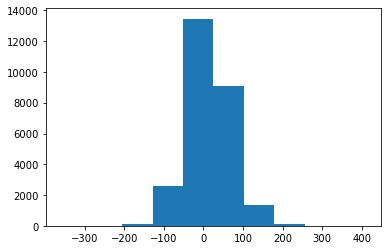

In [51]:
# Histogram of errors
import matplotlib.pyplot as plt
plt.hist(errors, bins=10)

Text(0.5, 1.0, 'Residual v.s Predicted Value')

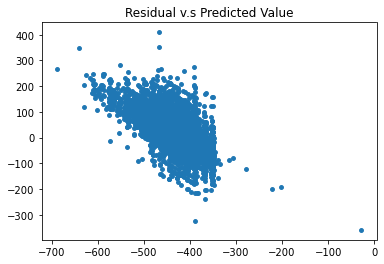

In [52]:
# Residual v.s Predicted Value
plt.scatter(test_predictions.flatten(), errors, s=15);
plt.title("Residual v.s Predicted Value")